# Chest-prediction - V2


## Setup

In [1]:
import tensorflow as tf

tf.__version__

'2.15.0'

In [2]:
AUTOTUNE = tf.data.AUTOTUNE

## Download and inspect the dataset

### Retrieve the images

Before you start any training, you'll need to download the dataset. I already resized the original dataset of the images to pass from 45GB to 3GB.

In [3]:
import os
from pathlib import Path

project_name = "chest-predictor"
username = os.environ.get('USER')

#Set variables (origin url, destination folder, folder name)
data_url = 'https://storage.googleapis.com/chest-predictor-data/resized_dataset.zip' 
data_dir = f"/Users/{username}/code/sachamagier/{project_name}/raw_data"
data_fname = 'resized_dataset.zip'


#Downloading the dataset
data_root_orig = tf.keras.utils.get_file(
    fname=os.path.join(data_dir, data_fname),
    origin=data_url
)

Unzip the dataset download from GCS

In [ ]:
import zipfile

#Extract the dataset
with zipfile.ZipFile(data_root_orig, 'r') as zip_ref:
    zip_ref.extractall(data_dir)

In [4]:
#Set the new data_root
data_root = Path(os.path.join(data_dir, 'resized_dataset'))
print(data_root)

/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset


In [ ]:
#This remove the '__MACOSX' file that is created on Mac Laptops
import shutil

if Path(os.path.join(data_dir, "__MACOSX")).is_dir():
    # remove the __MACOSX folder if it exists
    shutil.rmtree("../raw_data/__MACOSX")

In [5]:
#Get all image paths
all_image_paths = [str(path) for path in (data_root/"images"/"set_full").iterdir()]

In [6]:
image_count = len(all_image_paths)
image_count

112120

In [7]:
all_image_paths[:10]

['/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00018805_001.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00005868_002.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00009663_000.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00022156_007.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00005395_004.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00006966_004.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00000324_013.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00007442_018.png',
 '/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/se

### Inspect the images
Now let's have a quick look at a couple of the images, so you know what you're dealing with:

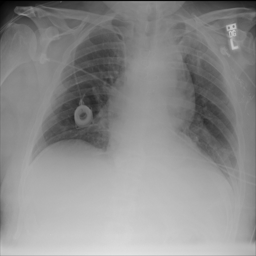

00006699_015.png



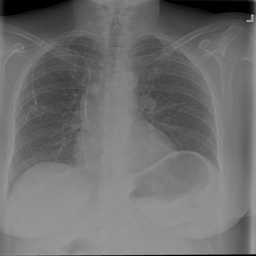

00029115_002.png



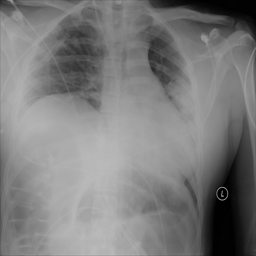

00016705_007.png



In [8]:
import IPython.display as display
import random

for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    print(os.path.basename(image_path))
    print()

### Determine the label for each image

Extracting the labels from the CSV

In [9]:
import pandas as pd

labels_df = pd.read_csv(data_root/"Data_Entry_2017.csv")

In [10]:
#Setting the image index as index of the DF
labels_df.set_index('Image Index', inplace=True)

In [11]:
labels_df.head(5)

,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
Image Index,,,,,,,,,,,
00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


Creating a list of all the labels for each image

In [12]:
# Create a list of all image labels
all_image_labels = []
for image_path in all_image_paths:
    # Get the image name from its file path
    image_name = os.path.basename(image_path)
    # Get the image label from the DataFrame
    image_label = labels_df.loc[image_name, 'Finding Labels']
    
    all_image_labels.append(image_label)

# Print the first 100 image labels
print("First 25 image labels: ", all_image_labels[:25])

First 25 image labels:  ['No Finding', 'No Finding', 'No Finding', 'Pneumonia', 'No Finding', 'Pneumonia', 'No Finding', 'No Finding', 'No Finding', 'No Finding', 'No Finding', 'Atelectasis|Infiltration', 'Fibrosis', 'Infiltration', 'No Finding', 'No Finding', 'No Finding', 'No Finding', 'No Finding', 'Atelectasis', 'Infiltration|Pneumonia', 'Cardiomegaly', 'Infiltration', 'Consolidation', 'No Finding']


In [13]:
len(all_image_labels)

112120

#### Encoding the labels

In [14]:
#Creating a list of the 15 different labels
label_names = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'No Finding']

Encoding the labels using *StringLookup*

In [15]:
string_lookup = tf.keras.layers.StringLookup(vocabulary=label_names, num_oov_indices=0)

In [16]:
#Encoding the individual labels
def encode_value(labels):
    parts = labels.split('|')
    encoded_parts = string_lookup(parts)
    return tf.reduce_sum(tf.one_hot(encoded_parts, depth=len(label_names)), axis=0)

In [17]:
#Encoding all values
encoded_values = [encode_value(labels) for labels in all_image_labels]

In [ ]:
#Converting to numpy array for printing
encoded_values_np = tf.stack(encoded_values).numpy()

In [ ]:
print("Encoded values:")
print(encoded_values_np[:25])

In [ ]:
#Checking the lenght
len(encoded_values_np)

If we need to find back the labels, here is the dictionnary of labels

In [18]:
vocab = string_lookup.get_vocabulary()

# Display the vocabulary and their corresponding indices
for i, label in enumerate(vocab):
    print(f"Index {i}: {label}")

Index 0: Atelectasis
Index 1: Consolidation
Index 2: Infiltration
Index 3: Pneumothorax
Index 4: Edema
Index 5: Emphysema
Index 6: Fibrosis
Index 7: Effusion
Index 8: Pneumonia
Index 9: Pleural_Thickening
Index 10: Cardiomegaly
Index 11: Nodule
Index 12: Mass
Index 13: Hernia
Index 14: No Finding


### Load and format the images

In [19]:
img_path = all_image_paths[0]
img_path

'/Users/arnodebelle/code/sachamagier/chest-predictor/raw_data/resized_dataset/images/set_full/00018805_001.png'

here is the raw data:

In [20]:
img_raw = tf.io.read_file(img_path)
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x00\x00\...


Decode it into an image tensor:

In [46]:
img_tensor = tf.image.decode_image(img_raw)

print(img_tensor.shape)
print(img_tensor.dtype)
print(img_tensor[0])

(256, 256, 1)
<dtype: 'uint8'>
tf.Tensor(
[[ 34]
 [ 14]
 [  4]
 [  1]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  1]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  1]
 [  9]
 [ 21]
 [ 27]
 [ 35]
 [ 50]
 [ 73]
 [ 90]
 [104]
 [115]
 [124]
 [144]
 [166]
 [180]
 [192]
 [202]
 [200]
 [198]
 [199]
 [199]
 [200]
 [197]
 [190]
 [195]
 [195]
 [190]
 [190]
 [193]
 [199]
 [196]
 [197]
 [198]
 [199]
 [197]
 [191]
 [188]
 [189]
 [185]
 [183]
 [184]

In [ ]:
img_final = tf.image.resize(img_tensor, [256, 256])
print(img_final.dtype)
img_final = img_final/255.0
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

Let's wrap up these up in simple functions for later.

In [49]:
def preprocess_image(image):
    # If the image has 4 color channels (including an alpha channel),
    # convert it to rgb
    image = tf.image.grayscale_to_rgb(image)

    # Resize the image to a width and a height of 256 pixels
    image = tf.image.resize(image, [256, 256], method='nearest')
    # Normalize the pixel values of the image to the range of [0, 1]
    #image /= 255.0

    return image

In [50]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    # Decode the image contents
    img_tensor = tf.image.decode_png(image)[:,:,0:1]
    return preprocess_image(img_tensor)

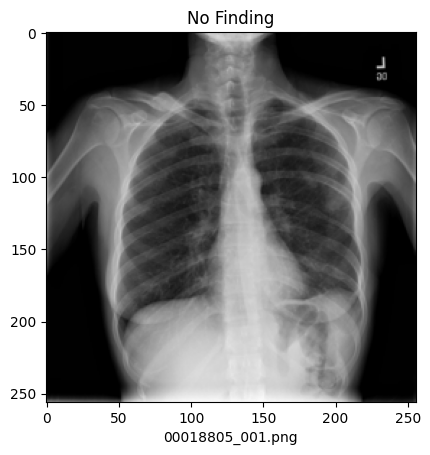

In [51]:
import matplotlib.pyplot as plt

img_path = all_image_paths[0]
label = all_image_labels[0]
encoded_lab = encoded_values[0]

plt.imshow(load_and_preprocess_image(img_path), cmap="gray")
plt.grid(False)
plt.xlabel(os.path.basename(img_path))
plt.title(label.title())
print()

## Build a `tf.data.Dataset`

### A dataset of images

The easiest way to build a tf.data.Dataset is using the from_tensor_slices method.

Slicing the array of strings results in a dataset of strings:

In [25]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

In [26]:
path_ds

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [ ]:
for p in path_ds.take(6):
    print(p)

Now create a new dataset that loads and formats images on the fly by mapping `preprocess_image` over the dataset of paths.

In [27]:
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

In [28]:
image1 = image_ds.take(3)
for i in image1:
    print(i)

tf.Tensor(
[[[ 34.  34.  34.]
  [ 14.  14.  14.]
  [  4.   4.   4.]
  ...
  [  1.   1.   1.]
  [  2.   2.   2.]
  [  2.   2.   2.]]

 [[ 34.  34.  34.]
  [ 14.  14.  14.]
  [  4.   4.   4.]
  ...
  [  1.   1.   1.]
  [  2.   2.   2.]
  [  2.   2.   2.]]

 [[ 33.  33.  33.]
  [ 13.  13.  13.]
  [  4.   4.   4.]
  ...
  [  1.   1.   1.]
  [  2.   2.   2.]
  [  2.   2.   2.]]

 ...

 [[ 53.  53.  53.]
  [ 42.  42.  42.]
  [ 42.  42.  42.]
  ...
  [ 13.  13.  13.]
  [ 22.  22.  22.]
  [ 31.  31.  31.]]

 [[ 81.  81.  81.]
  [ 72.  72.  72.]
  [ 74.  74.  74.]
  ...
  [ 24.  24.  24.]
  [ 33.  33.  33.]
  [ 44.  44.  44.]]

 [[118. 118. 118.]
  [112. 112. 112.]
  [114. 114. 114.]
  ...
  [ 39.  39.  39.]
  [ 48.  48.  48.]
  [ 60.  60.  60.]]], shape=(256, 256, 3), dtype=float32)
tf.Tensor(
[[[248. 248. 248.]
  [221. 221. 221.]
  [163. 163. 163.]
  ...
  [  9.   9.   9.]
  [ 10.  10.  10.]
  [  7.   7.   7.]]

 [[220. 220. 220.]
  [164. 164. 164.]
  [103. 103. 103.]
  ...
  [  9.   9.   9.]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..252.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [4.0..251.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..253.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..241.0].


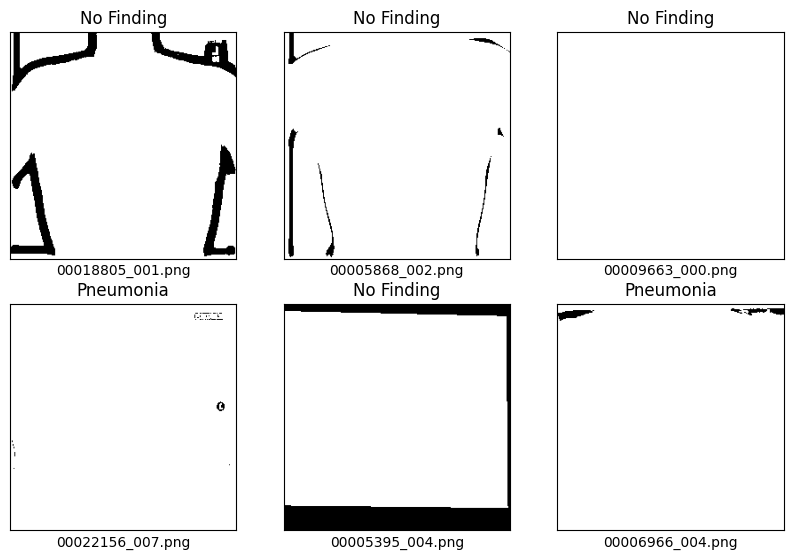

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for n,image in enumerate(image_ds.take(6)):
    ax = plt.subplot(3,3,n+1)
    plt.imshow(image, cmap='gray')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(os.path.basename(all_image_paths[n]))
    plt.title(all_image_labels[n].title())

plt.show()

### A dataset of `(image, label)` pairs


Using the same `from_tensor_slices` method you can build a dataset of labels

In [30]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(encoded_values, tf.int32))

In [31]:
for label in label_ds.take(25):
  print(label)

tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 1], shape=(15,), dtype=int32)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 1], shape=(15,), dtype=int32)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 1], shape=(15,), dtype=int32)
tf.Tensor([0 0 0 0 0 0 0 0 1 0 0 0 0 0 0], shape=(15,), dtype=int32)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 1], shape=(15,), dtype=int32)
tf.Tensor([0 0 0 0 0 0 0 0 1 0 0 0 0 0 0], shape=(15,), dtype=int32)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 1], shape=(15,), dtype=int32)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 1], shape=(15,), dtype=int32)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 1], shape=(15,), dtype=int32)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 1], shape=(15,), dtype=int32)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 1], shape=(15,), dtype=int32)
tf.Tensor([1 0 1 0 0 0 0 0 0 0 0 0 0 0 0], shape=(15,), dtype=int32)
tf.Tensor([0 0 0 0 0 0 1 0 0 0 0 0 0 0 0], shape=(15,), dtype=int32)
tf.Tensor([0 0 1 0 0 0 0 0 0 0 0 0 0 0 0], shape=(15,), dtype=int32)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0

We have arrays `all_image_labels` and `all_image_paths` so We can use `tf.data.dataset.Dataset.zip` to slicing the pair of arrays.

In [32]:
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, encoded_values))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)
image_label_ds

<_MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(15,), dtype=tf.float32, name=None))>

### Basic methods for training


To train a model with this dataset we want the data:

* To be well shuffled.
* To be batched.
* To repeat forever.
* To have batches available as soon as possible.

These features can be easily added using the `tf.data` api.

In [33]:
BATCH_SIZE = 32

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

In [34]:
ds.take(6)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None))>

### Pipe the dataset to a model


In [ ]:
for image, label in ds.take(6):
    print(image.numpy().shape)

In [35]:
from tensorflow.keras.applications.vgg16 import VGG16

def load_model():

    model = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

    return model

In [36]:
model = load_model()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [37]:
def set_nontrainable_layers(model):

    # Set the first layers to be untrainable
    model.trainable = False

    return model

In [38]:
from tensorflow.keras import layers, models

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    prediction_layer = layers.Dense(15, activation='sigmoid')


    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])
    return model

In [ ]:
from sklearn.metrics import f1_score

def multilabel_f1_score(y_true, y_pred):
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)  # thresholding the predictions

    # Wrap the f1_score function from scikit-learn with tf.py_function
    f1, _ = tf.py_function(f1_score, [y_true, y_pred], [tf.float32, tf.float32])

    # The output of tf.py_function is a list of tensors, so we need to extract the first tensor
    f1 = f1[0]

    # The f1_score function from scikit-learn returns the average f1_score across all labels,
    # so we need to divide the f1_score by the number of labels to get the f1_score per label
    batch_size = tf.cast(tf.shape(y_true)[0], tf.float32)
    f1 /= batch_size

    return f1

In [39]:
from tensorflow.keras import optimizers

def build_model():
    model = load_model()
    model = add_last_layers(model)

    opt = optimizers.legacy.Adam(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])#[multilabel_f1_score])
    return model

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

model = build_model()

es = EarlyStopping(monitor='val_accuracy', #'val_multilabel_f1_score',  # the name of the metric will be its prefix + '_' + its function name
                   mode='max',
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

In [41]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

3504.0

In [42]:
train_ds = ds.take(int(0.8 * len(all_image_paths)))
val_ds = ds.skip(int(0.8 * len(all_image_paths)))

In [43]:
EPOCHS = 1

history = model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[es])

2024-06-06 17:03:24.381109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-06-06 17:03:26.288354: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:11,RepeatDataset:12): Filling up shuffle buffer (this may take a while): 43355 of 112120
2024-06-06 17:03:30.038895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG
2024-06-06 17:03:46.285508: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] fused(ShuffleDatasetV3:11,RepeatDataset:12): Filling up shuffle buffer (this may take a while): 101002 of 112120
2024-06-06 17:03:49.428803: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


   80/89696 [..............................] - ETA: 100:28:54 - loss: 0.7222 - accuracy: 0.3957

KeyboardInterrupt: 